**Báo cáo BTL Học máy**

* Mã lớp: INT3405E 20
* Sinh viên: Hà Long Việt
* MSSV: 19021393

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. Vấn đề**
* Quora là nơi tất cả mọi người có thể đăng các câu hỏi. Các câu trả lời có thể đến từ những người nổi tiếng, doanh nhân, nhà khoa học, giáo sư đại học hay bất cứ ai. Các câu trả hay được upvote để đảm bảo chất lượng.
* Một vấn đề tồn tại đối với bất kỳ trang web lớn nào hiện nay là làm thế nào để xử lý nội dung độc hại và gây chia rẽ. Quora muốn giải quyết vấn đề này trực tiếp để giữ cho nền tảng của họ trở thành một nơi mà người dùng có thể cảm thấy an toàn khi chia sẻ kiến thức của họ với thế giới.
*Mục tiêu: tìm và lọc ra các câu hỏi được xem là không phù hợp trên Quora.

Mô tả bài toán:
* Đầu vào : dữ liệu các câu hỏi dưới dạng text.
* Đầu ra : phân loại được câu hỏi là insincere hay sincere.

# **2. Phân tích dữ liệu**

Mô tả tệp:
* train.csv - tập huấn luyện
* test.csv - bộ thử nghiệm

Các trường dữ liệu:
* qid - mã định danh câu hỏi duy nhất
* question_text - câu hỏi Quora
* target - câu hỏi có nhãn "insincere" có giá trị bằng 1, ngược lại bằng 0

In [ ]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import warnings
import string

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack
from IPython.display import Image
from tqdm import tqdm_notebook

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
print(os.listdir("../input"))

> Xem qua về các tệp input được cung cấp:

In [ ]:
#Đọc dữ liệu
train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
sub = pd.read_csv('../input/quora-insincere-questions-classification/sample_submission.csv')

print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

In [ ]:
train.info()

> Ta thấy:
> * Dữ liệu train bao gồm 1306122 dòng và 3 cột
> * Dữ liệu huấn luyện không có giá trị null

In [ ]:
train["target"].value_counts()

In [ ]:
train[train['target']==0].head()

In [ ]:
train[train['target']==1].head()

> * Trường *'target'* phân loại câu hỏi bằng hai giá trị là 0, 1 với 0 là các câu hỏi sincere và 1 là các câu hỏi insincere
> * Dữ liệu train gồm 80810 dòng đã được xác nhận là câu hỏi insincere và 1225312 dòng là sincere
> * Khi nhìn vào trường target: các giá trị không cân bằng, giá trị '0' nhiều hơn giá trị '1' gấp nhiều lần *

In [ ]:
print("Tổng dữ liệu trong tập train : ",train.shape[0])
print("Số câu hỏi chân thành: ", len(train[train.target == 0]))
print("Số câu hỏi không chân thành: ",len(train[train.target == 1]))
print("Tỉ lệ giữa 2 thành phần: ",len(train[train.target == 1])/len(train[train.target == 0]))
print('\n')
ax, fig = plt.subplots(figsize=(10, 7))
question_class = train["target"].value_counts()
question_class.plot(kind= 'bar', color= ["red", "yellow"])
plt.title('Bar chart')
plt.show()

In [ ]:
print('- Phần trăm câu hỏi sincere : {}%'.format(100 - round(train['target'].mean() * 100, 2))) 
print('- Phần trăm câu hỏi insincere : {}%'.format(round(train['target'].mean() * 100, 2)))

**Nhận xét:**

Ta thấy: "Sincere question" có hơn 1,2 triệu câu hỏi, chiếm 93.81% tập train, chỉ có 6.19% cho "Insincere question" với khoảng gần 81,000 câu hỏi. Dữ liệu cực mất cân bằng khi sincere question nhiều hơn 15 lần so với insincere question.

**Khảo sát Word Cloud:** 
* là một kỹ thuật trực quan hóa dữ liệu được sử dụng để biểu diễn dữ liệu văn bản, trong đó kích thước của mỗi từ cho biết tần suất hoặc tầm quan trọng của nó.
* Từ nào xuất hiện nhiều kích thước sẽ càng lớn và ngược lại.

In [ ]:
sin = train[train['target']==0]
insin = train[train['target']==1]
def wcloud(docs, title):
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color="white").generate(" ".join(docs))
    fig = plt.figure(figsize=(10,7), facecolor='none')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=25,color='k')
    plt.tight_layout(pad=0)
    plt.show()
wcloud(sin.question_text, "Sincere question")
wcloud(insin.question_text, "Insincere question")

# **3. Data processing**

Clean data
* Loại bỏ stopwords: là các từ được lọc ra trước hoặc sau quá trình xử lý dữ liệu văn bản
* Lemmatize: đưa chữ về một dạng thống nhất
* Tokenization: xóa bỏ các khoảng trắng thừa, chuẩn hóa chữ cái viết hoa, xử lý các kí tự số

In [ ]:
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

wordnet_lemmatizer = WordNetLemmatizer()

def lemSentence(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence = []
    for word in token_words:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        lem_sentence.append(" ")
    return "".join(lem_sentence)

def clean(message, lem=True):
    # Loại bỏ dấu câu
    message = message.translate(str.maketrans('', '', string.punctuation))
    
    # loại bỏ chữ số
    message = message.translate(str.maketrans('', '', string.digits))
    
    # loại bỏ stop words
    message = [word for word in word_tokenize(message) if not word.lower() in nltk_stopwords]
    message = ' '.join(message)
    
    # Lemmatization
    if lem:
        message = lemSentence(message)
    
    return message

In [ ]:
#Bắt đầu clean dữ liệu trên tập train
train['question_text_cleaned'] = train.question_text.apply(lambda x: clean(x, True))

> * Tách dữ liệu để đánh giá mô hình.
> * Ta sử dụng hàm chia dữ liệu đã được cho trước trong thư viện sklearn.

In [ ]:
from sklearn.model_selection import train_test_split

# chia dữ liệu tập train và tập test theo tỷ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(train['question_text_cleaned'], train['target'], test_size=0.2, random_state=42)

# **4. Huấn luyện model**

**Metric**: Ta sẽ sử dụng f1-score thay thế cho accuracy khi mô hình có tỷ lệ mất cân bằng mẫu cao.
* F1-score là trung bình điều hòa (harmonic mean) của precision và recall (giả sử hai đại lượng này khác 0). F1-score được tinh theo công thức:

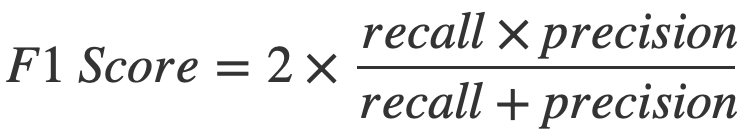

Trong đó:
* Precision được định nghĩa là tỉ lệ số điểm true positive trong số những điểm được phân loại là positive (TP + FP).
* Recall được định nghĩa là tỉ lệ số điểm true positive trong số những điểm thực sự là positive (TP + FN).

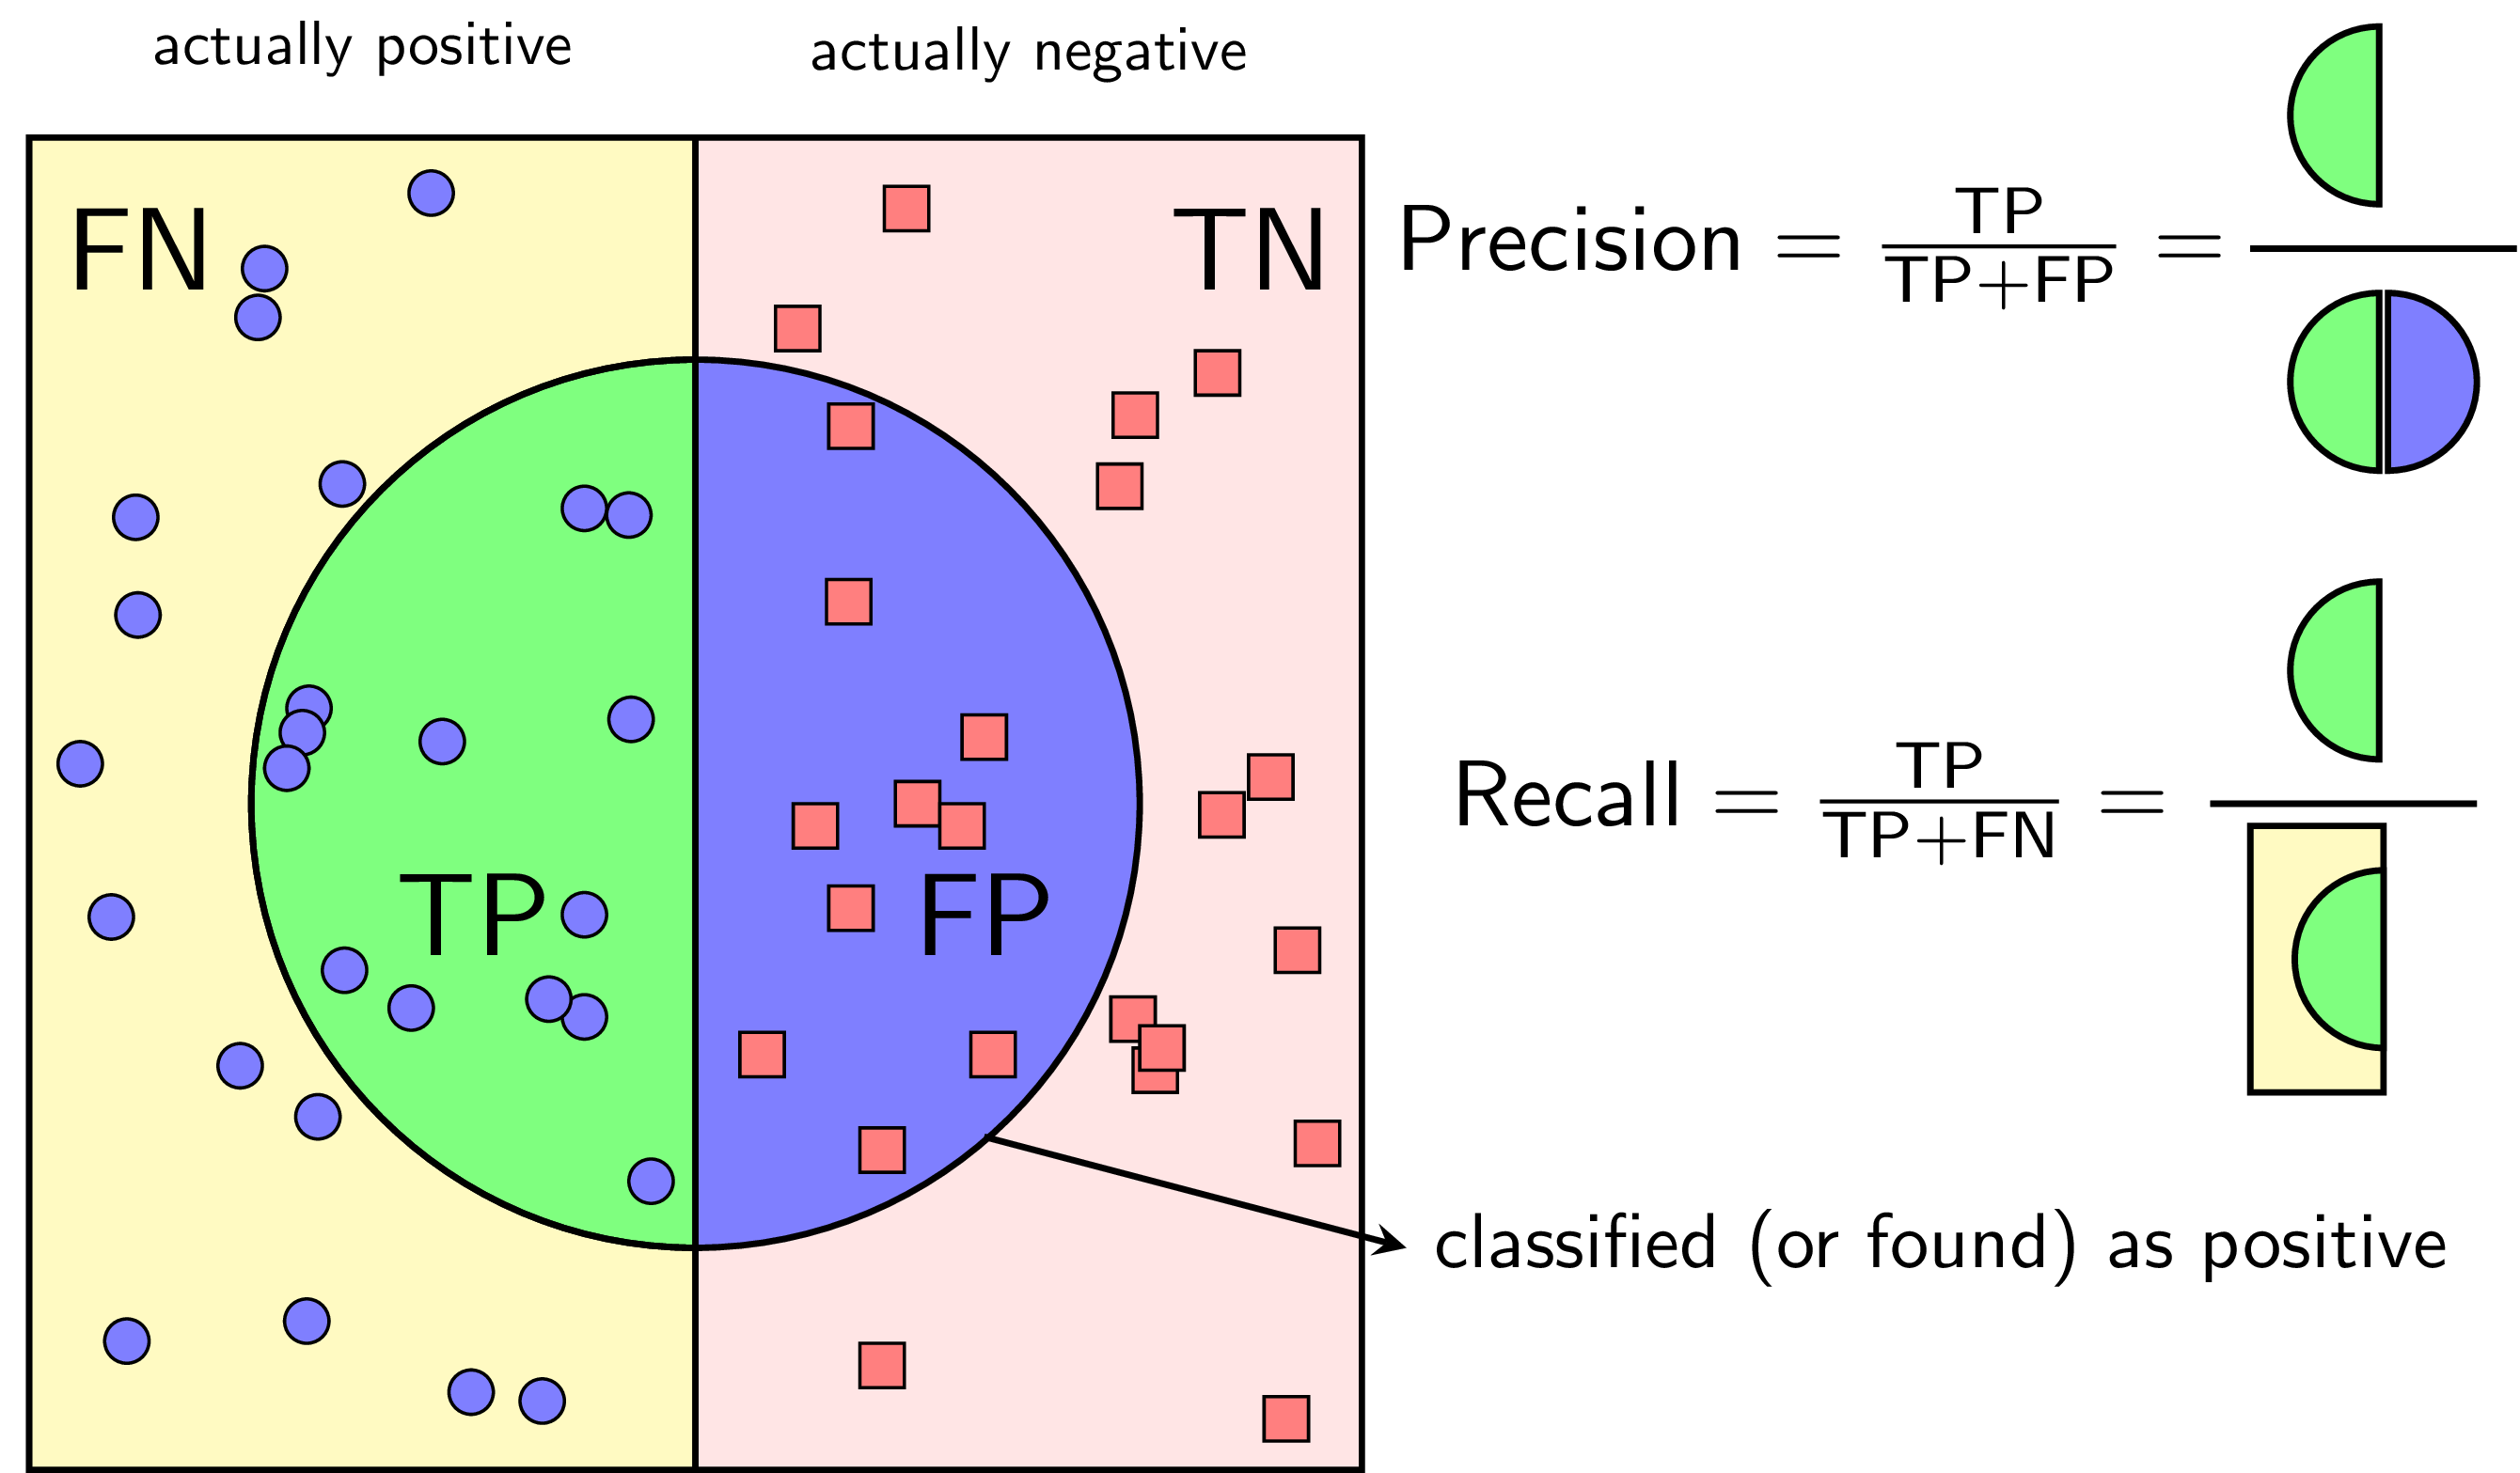

> **Vectorization:**
>  
> * CountVectorizer: để sử dụng dữ liệu văn bản cho mô hình dự đoán, văn bản phải được phân tích cú pháp để loại bỏ một số từ nhất định - quá trình này được gọi là mã hóa . Sau đó, những từ này cần được mã hóa dưới dạng số nguyên hoặc giá trị dấu phẩy động, để sử dụng làm đầu vào trong thuật toán học máy. Quá trình này được gọi là trích xuất đặc trưng (hoặc vectơ hóa).

> **Pipeline:**
> 
> * là một tập các chuỗi thuật toán để trích xuất đặc trưng, tiền xử lý, chuyển hóa và huấn luyện dữ liệu sử dụng các thuật toán học máy cụ thể.
> * phương thức fit để huấn luyện estimator tại bước cuối cùng của pipeline.
> * dự đoán đầu ra cho dữ liệu mới bằng cách sử dụng phương thức predict.


**Bắt đầu huấn luyện mô hình:**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))

# **Naive Bayes**

* Theo định lý Bayes, ta có công thức tính xác suất ngẫu nhiên của sự kiện y khi biết x như sau:

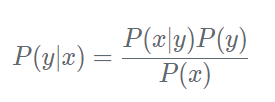

* Giả sử ta phân chia 1 sự kiện x thành n thành phần khác nhau x1, x2,..., xn. Naive Bayes theo đúng như tên gọi dựa vào một giả thiết ngây thơ rằng x1, x2,...xn là các thành phần độc lập với nhau. Từ đó ta có thể tính được:

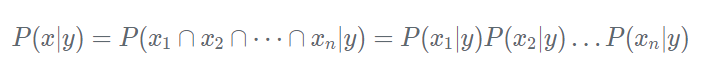

* Do đó ta có:

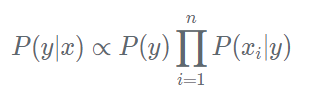

Ta sẽ áp dụng Multinomial Naive Bayes.

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

model1 = MultinomialNB(alpha=0.08)

vectorize_model_pipeline1 = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('model', model1)])
vectorize_model_pipeline1.fit(X_train, y_train)
predictions1 = vectorize_model_pipeline1.predict(X_test)

print('Accuracy :', accuracy_score(y_test, predictions1))
print('F1 score :', f1_score(y_test, predictions1))

# [**Logistic Regression**](http://excessive-source-1c9.notion.site/16-09-2021-H-i-quy-Logistics-cdcc911147e5458ba9203b58e6bd0099#dd32774a49cc44ac81c61578b831ad47)

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression(n_jobs=10, solver='saga', class_weight = 'balanced', C=0.1, verbose=1)

vectorize_model_pipeline2 = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('model', model2)])
vectorize_model_pipeline2.fit(X_train, y_train)
predictions2 = vectorize_model_pipeline2.predict(X_test)

print('Accuracy :', accuracy_score(y_test, predictions2))
print('F1 score :', f1_score(y_test, predictions2))

# **XGBoost**

* XGBoost là viết tắt của Extreme Gradient Boosting. Đây là thuật toán state-of-the-art nhằm giải quyết bài toán supervised learning cho độ chính xác khá cao bên cạnh mô hình Deep learning như chúng ta từng tìm hiểu.
* Được base trên gradient boosting, tuy nhiên kèm theo đó là những cải tiến to lớn về mặt tối ưu thuật toán, về sự kết hợp hoàn hảo giữa sức mạnh phần mềm và phần cứng, giúp đạt được những kết quả vượt trội cả về thời gian training cũng như bộ nhớ sử dụng.

In [ ]:
#XGBoost
from xgboost import XGBClassifier

model3 = XGBClassifier()

vectorize_model_pipeline3 = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('model', model3)])
vectorize_model_pipeline3.fit(X_train, y_train)
predictions3 = vectorize_model_pipeline3.predict(X_test)

print('Accuracy :', accuracy_score(y_test, predictions3))
print('F1 score :', f1_score(y_test, predictions3))

# **5. Submission**

In [ ]:
model_result = pd.DataFrame({
    'Model': ['Naive Bayes','Logistic Regression','Xgboost'],
    'F1 score': [f1_score(y_test, predictions1),
              f1_score(y_test, predictions2),
              f1_score(y_test, predictions3)]})

model_result

**Kết luận**

* Nhìn chung các mô hình đơn giản như Naive Bayes, Logistic Regression và XGBoost đều hoạt động khá ổn trên tập dataset.
* Cho ra kết quả tương đối khả quan. Tuy vậy, vẫn chưa thực sự đủ tốt cho việc phân loại câu hỏi, nên sử dụng một mô hình khác đối với bài toán này.
* Mô hình Logistic Regression cho ra f1-score cao nhất nên ta sẽ dùng để submit.

**Sau khi train xong, chạy mô hình trên tập test và lưu lại để submit**

In [ ]:
#Clean data trên tập test
test['question_text_cleaned'] = test.question_text.apply(lambda x: clean(x, True))

In [ ]:
test['prediction'] = vectorize_model_pipeline2.predict(test['question_text_cleaned'])

In [ ]:
final_sub = test[['qid','prediction']]
final_sub.set_index('qid', inplace=True)
final_sub.head(10)

In [ ]:
final_sub.to_csv('submission.csv')